# Problem 1

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Import the datasets
train_data = pd.read_csv('healthcareTrain.csv')
test_data = pd.read_csv('healthcareTest.csv')

features =  ['pre_rx_cost', 'numofgen', 'numofbrand', 'generic_cost', 'adjust_total_30d', 'num_er']
label = 'pdc_80_flag'

train_x = train_data[features].values
train_y = train_data[label].values

test_x = test_data[features].values
test_y = test_data[label].values

In [4]:
# Build KNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

result = {}
best_k = 0
best_accuracy = 0.0
for k in range(75, 106, 2):

    knn_classifier = Pipeline(
        steps=[
            ('Normalize', MinMaxScaler()),
            ('KNN', KNeighborsClassifier(n_neighbors=k, metric='euclidean'))
        ]
    )

    knn_classifier.fit(train_x, train_y)
    predict_val = knn_classifier.predict(test_x)
    accuracy = accuracy_score(test_y, predict_val)
    result[k] = accuracy

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k


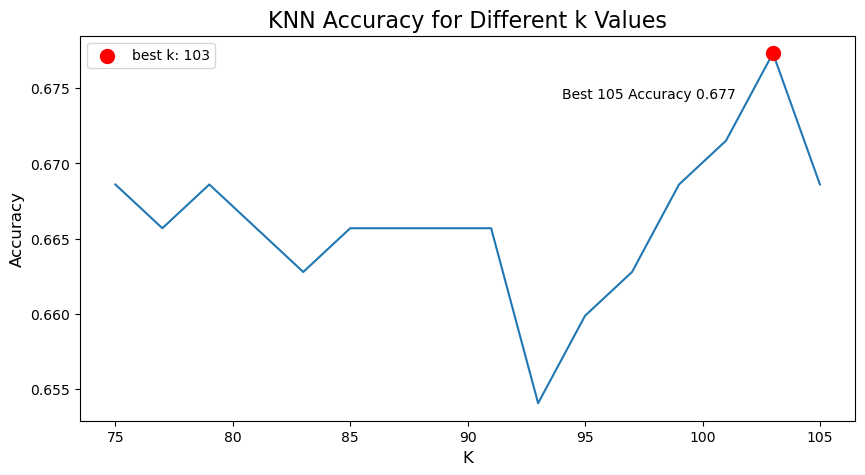

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(result.keys(), result.values())

plt.xlabel('K', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.title("KNN Accuracy for Different k Values", fontsize = 16)
plt.scatter(best_k, best_accuracy, color = 'red', s=100, zorder = 2, label=f"best k: {best_k}")
plt.text(best_k - 9, best_accuracy - 0.003 , f"Best {k} Accuracy {best_accuracy:.3f}")
plt.legend()
plt.show()

In [6]:
print(f"When K = {best_k}, got the best accuracy = {best_accuracy:.3f}")

When K = 103, got the best accuracy = 0.677


# Problem 2

In [7]:
region_count = train_data.groupby(['regionN', label]).size().unstack()
region_all  = train_data.groupby(['regionN']).size()

In [8]:
region_prob = region_count.div(region_all, axis=0)
region_prob

pdc_80_flag,0,1
regionN,,
1,0.495495,0.504505
2,0.568579,0.431421
3,0.645995,0.354005
4,0.576087,0.423913


In [9]:
# 4 categories
num_categories = np.arange(1, 5, 1)
vdm_dist = pd.DataFrame(index=num_categories, columns=num_categories)


for row in num_categories:
    for col in num_categories: 
        if row == col:
            vdm_dist.loc[row, col] = 0.0
        else:
            prob_1 = region_prob.loc[row].values
            prob_2 = region_prob.loc[col].values

            distance = np.sum((prob_1 - prob_2) ** 2)

            vdm_dist.loc[row, col] = distance
vdm_dist    
        

,1,2,3,4
1,0.0,0.010682,0.0453,0.01299
2,0.010682,0.0,0.011987,0.000113
3,0.0453,0.011987,0.0,0.009774
4,0.01299,0.000113,0.009774,0.0


In [10]:
# Re import the data

train_data = pd.read_csv('healthcareTrain.csv')
test_data = pd.read_csv('healthcareTest.csv')

train_x = train_data[features].values
train_y = train_data[label].values

test_x = test_data[features].values
test_y = test_data[label].values


# Normalize
train_x_min = train_x.min()
train_x_max = train_x.max()

train_x_normal = (train_x - train_x_min) / (train_x_max - train_x_min)
test_x_normal = (test_x - train_x_min) / (train_x_max - train_x_min)

In [11]:
# Manuall KNN with VDM 
train_cat = train_data['regionN'].values
test_cat = test_data['regionN'].values


best_accuracy_vdm = 0.0
best_k_vdm = 0
result_vdm = {}
for k in range(75, 106, 2):

    current_predictions = []

    for index_test, test_point in enumerate(test_x_normal):

        distances = []
        for index_train, train_point in enumerate(train_x_normal):
            
            num_distance = np.sum(((test_point - train_point) ** 2))
            cat_distance = np.sum(vdm_dist.loc[test_cat[index_test], train_cat[index_train]])
            total_distance = np.sqrt(cat_distance + num_distance)
            distances.append((total_distance, train_y[index_train]))

        distances.sort()
        distances = distances[:k]

        label_list = []
        for val, label in distances:
            label_list.append(label)
                
        occurance = np.bincount(label_list)
        predict_val_with_vdm = np.argmax(occurance)

        current_predictions.append(predict_val_with_vdm)

    accuracy_with_vdm = np.sum(test_y == current_predictions) / len(test_y)
    result_vdm[k] = accuracy_with_vdm

    if accuracy_with_vdm >  best_accuracy_vdm:
        best_accuracy_vdm = accuracy_with_vdm
        best_k_vdm = k


In [12]:
print(f"Get best k {best_k_vdm} with accuracy {best_accuracy_vdm:.3f} from KNN VDM")
print(f"Get best k {best_k} with accuracy {best_accuracy:.3f} from KNN")

Get best k 99 with accuracy 0.651 from KNN VDM
Get best k 103 with accuracy 0.677 from KNN


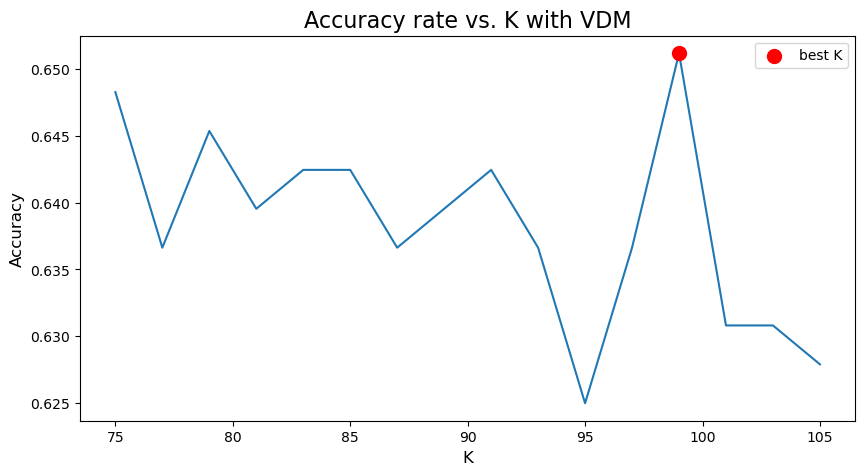

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(result_vdm.keys(), result_vdm.values())
plt.title('Accuracy rate vs. K with VDM', fontsize = 16)
plt.xlabel('K', fontsize = 12)
plt.ylabel('Accuracy', fontsize =12)

plt.scatter(best_k_vdm, best_accuracy_vdm, s=100, color = 'red', zorder = 2, label='best K')

plt.legend()
plt.show()

In [14]:
current_predictions = []

for index_test, test_point in enumerate(test_x_normal):

    distances = []
    for index_train, train_point in enumerate(train_x_normal):
        
        num_distance = np.sum(((test_point - train_point) ** 2))
        cat_distance = np.sum(vdm_dist.loc[test_cat[index_test], train_cat[index_train]])
        total_distance = np.sqrt(cat_distance + num_distance)
        distances.append((total_distance, train_y[index_train]))

    distances.sort()
    # Use best K to predict
    distances = distances[:best_k_vdm]

    label_list = []
    for val, label in distances:
        label_list.append(label)
            
    occurance = np.bincount(label_list)
    predict_val_with_vdm = np.argmax(occurance)

    current_predictions.append(predict_val_with_vdm)

print(f"KNN with VDM predictions")
print(f"100th {current_predictions[99]}")
print(f"200th {current_predictions[199]}")
print(f"300th {current_predictions[299]}")

KNN with VDM predictions
100th 0
200th 0
300th 0
